1. Como vai ser entregue o Produto Final?
  - Vai ser uma página no streamlit. onde o CEO vai poder acessar para verificar as análises

2.  Ferramentas que vão ser usadas?
  - Python 3.8
  - Jupyter Notebook
  - Visual code

3. Processos para resolver esse problema

  - Coleta dos dados.
  - Descrição dos dados.
  - Coletar dados Cidade e Estado via API.
  - Criar Hípoteses de negócios.
  - Responder as Hípoteses.
  - Depois Responder as perguntas do CEO.
  - Montar a página para publicar os insights.  

# 0.0 Imports

In [23]:
import os
import requests
import warnings
import datetime
import pandas         as pd
import numpy          as np
import seaborn        as sns
import plotly.express as px
import ipywidgets     as widgets
import zipfile     


from io                    import BytesIO
from scipy                 import stats  as ss
from ipywidgets            import fixed
from matplotlib            import gridspec
from matplotlib            import pyplot as plt
from geopy.geocoders       import Nominatim
from IPython.core.display  import HTML
from IPython.display       import Image

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

## 0.1 Helper functions

In [24]:
def calculate_cramer(lista, data):
    var = []
    a = [] 

    for i in range(3):
        x = lista[i]
    
        for j in lista:

            var = cramer_v(data[x], data[j])       
            a.append(var)

    data = pd.DataFrame({'condition_type':[a[0] ,a[1],a[2]],'is_waterfront':[a[3] ,a[4],a[5]],'county':[a[6] ,a[7],a[8]]})

    data = data.set_index(data.columns)
    sns.heatmap(data,annot=True);
    return None

# Correlação atributos categóricos
def cramer_v(x, y):
    '''This functions calculates the Cramér V, a measure of association between two nominal variables'''
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k - 1) * (r - 1) / (n - 1))
    
    kcorr = k - (k - 1) ** 2 / (n - 1)
    rcorr = r - (r - 1) ** 2 / (n - 1)
    
    return np.sqrt((chi2corr / n) / min(kcorr - 1, rcorr - 1))

# Correlação atributos numéricos
def calculate_correlation (atributos):

    correlation = num_attributes.corr(method='pearson')

    # Creating a with mask for the superior triangle
    ax = np.zeros_like(correlation)
    ax[np.triu_indices_from(ax)] = True
    corr_heatmap = sns.heatmap(correlation,mask=ax, annot=True,cmap="magma");

    return corr_heatmap 


# Estatística Descritiva
def num_metricas(num_attributes):
    
  #Central tendencian - mean, median
    ct1 = pd.DataFrame( num_attributes.apply(np.mean)).T
    ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

  #Dispersion - std, min, max, range, skew, kurtosis

    d1 = pd.DataFrame(num_attributes.apply(np.std)).T
    d2 = pd.DataFrame(num_attributes.apply(min)).T
    d3 = pd.DataFrame(num_attributes.apply(max)).T
    d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min() )).T
    d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew() )).T
    d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis() )).T

  #Concatenate
    metrics = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
    metrics.columns = ['attributes','min', 'max', 'range', 'mean', 'median', 'std', 'skew','kurtosis']
  
    return metrics

def jupyter_settings():
    
    %matplotlib inline 
    #%pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize']=[20,16]
    plt.rcParams['font.size']=10
    
    display( HTML('<style>.container {width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr',False )
    pd.set_option('display.float_format',lambda x: '%.2f' % x)
    
    sns.set()
    
jupyter_settings()

In [25]:
warnings.filterwarnings ('ignore')

## 0.2 Carregando os dados

In [33]:
#df_raw = pd.read_csv('/content/drive/MyDrive/project_house_rocket/data/kc_house_data.csv',low_memory=False) #dataset com alterações   index_col=0
df_raw = pd.read_csv('../data/kc_house_data.csv',low_memory=False) #dataset com alterações
df = df_raw.copy()
df.sample(5)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
18599,9424400110,20141216T000000,725000.00,2,1.00,2410,5930,2.00,0,0,3,9,1930,480,2007,0,98116,47.57,-122.39,1540,5892
15995,7625700305,20140605T000000,564000.00,3,1.75,1980,6250,1.00,0,1,5,7,1090,890,1910,0,98136,47.55,-122.39,1980,6250
13223,9521101520,20141212T000000,543000.00,2,1.00,940,3864,1.00,0,0,4,8,940,0,1918,0,98103,47.66,-122.34,1440,3956
229,7202340400,20150303T000000,516500.00,3,2.50,1480,4729,2.00,0,0,3,7,1480,0,2004,0,98053,47.68,-122.03,2250,4729
14577,8665050770,20140619T000000,505000.00,3,2.50,1610,4611,2.00,0,0,3,8,1610,0,1996,0,98029,47.57,-122.00,1730,4461


# 1.0 Descrição dos Dados

## 1.1. Dimensão dos Dados

In [6]:
print('Quantidade de linhas: {}'.format(df.shape[0]))
print('Quantidade de colunas: {}'.format(df.shape[1]))

Quantidade de linhas: 21613
Quantidade de colunas: 21


## 1.2. Tipos dos Dados

In [7]:
df.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

Podemos observar que a variável 'date' apresenta o tipo object como é uma data vamos realizar a mudança do tipo de variável.

In [8]:
df['date'] = pd.to_datetime(df['date'])

## 1.3 Check NA

In [9]:
df.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

**Obs:** O dataset não apresenta valores nulos.

## 1.4 Estatística Descritiva

In [10]:
#Separação das variáveis numéricas e categóricas
num_atributos = df.select_dtypes(include = ['int64', 'float64'])
cat_atributos = df.select_dtypes(include = ['object'])

### 1.4.1 Variáveis Numéricas

In [11]:
 num_metricas(num_atributos)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1000102.00,9900000190.00,9899000088.00,4580301520.86,3904930410.00,2876499023.43,0.24,-1.26
1,price,75000.00,7700000.00,7625000.00,540088.14,450000.00,367118.70,4.02,34.59
2,bedrooms,0.00,33.00,33.00,3.37,3.00,0.93,1.97,49.06
3,bathrooms,0.00,8.00,8.00,2.11,2.25,0.77,0.51,1.28
4,sqft_living,290.00,13540.00,13250.00,2079.90,1910.00,918.42,1.47,5.24
5,sqft_lot,520.00,1651359.00,1650839.00,15106.97,7618.00,41419.55,13.06,285.08
6,floors,1.00,3.50,2.50,1.49,1.50,0.54,0.62,-0.48
7,waterfront,0.00,1.00,1.00,0.01,0.00,0.09,11.39,127.63
8,view,0.00,4.00,4.00,0.23,0.00,0.77,3.40,10.89
9,condition,1.00,5.00,4.00,3.41,3.00,0.65,1.03,0.53


### 1.4.2 Variáveis Categóricas

In [12]:
cat_atributos.columns 

Index([], dtype='object')

Não temos variáveis categóricas neste dataset.

# 2.0 Feature Engineering

In [28]:
df2 = df.copy()

## 2.1 Mapa de Hípoteses

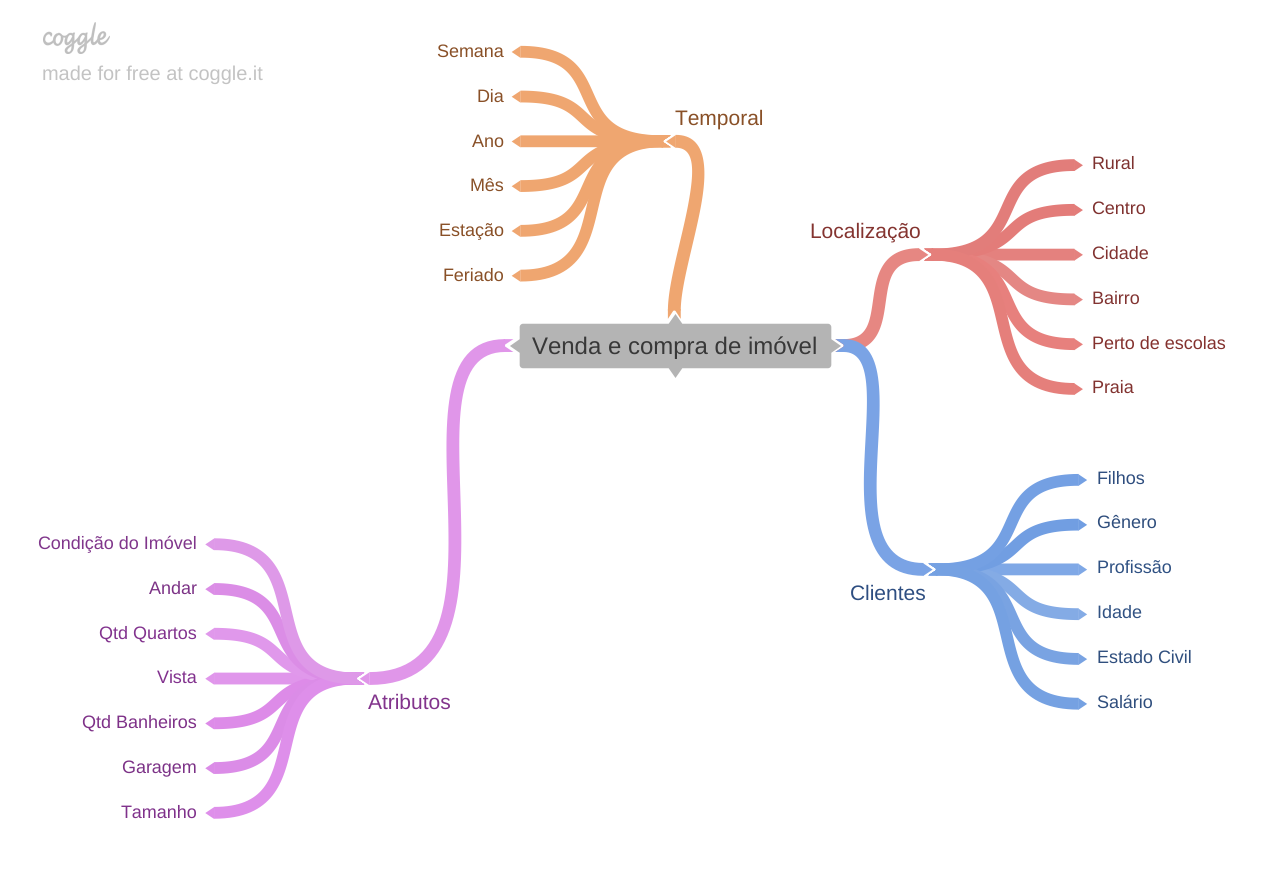

In [14]:
Image('../img/hipoteses.png')

## 2.2 Criação de Hípoteses

### Atributos 

1. Imóveis com 3 quartos vendem mais do  que imóveis com 2 quartos.
2. Imóveis com 2 pelo menos 2 banheiros vendem mais do que imóveis com 1 banheiro.
3. *Imóveis com vagas na garagem vendem mais do que imóveis sem vagas*
4. Imóveis com maior metragem maiores que 70 m2 vendem menos do que imóveis com metragem menores.
5. Imóveis com condições boas vendem mais do que imóveis com condições ruins.

### Tempo

1. São vendidos mais imóveis no 1º semestre do que no 2º semestre do ano
2. *Imóveis são mais vendidos em períodos de férias escolares.*
3. As vendas de imóveis nas estações outono e inverno é menor do que nas estações primavera e verão.
4. As vendas de imóveis até o dia 10 de todos os meses é maior que depois do que do resto do mês.

### Localização

1. *Imóveis com localização na praia vendem mais do que imóveis com localização no centro.*
2. *Imóveis com localização no centro vendem mais do que imóveis com localização em bairros.*

## 2.3 Feature Engineering

In [15]:
#year 
df2['year'] = df2['date'].dt.year

#month
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

### 2.3.1 Condition house

In [16]:
#Condition house
df2['condition_type']= df2['condition'].apply(lambda x: 'bad'  if x <= 2 else 
                                            'regular' if (x >= 3) & (x <= 4) 
                                            else 'good')

### 2.3.2 Level

In [17]:
#Level
df2['level']= df2['price'].apply(lambda x: 0  if x < 321950 else 
                                              1  if (x >= 321950) & (x < 450000) else 
                                              2  if (x >= 450000) & (x < 645000) else 3)  
df2['level'] = df2['level'].astype(int)

### 2.3.3 Size

In [18]:
#Size
df2['size']= df2['sqft_living'].apply(lambda x: 0  if x < 1427 else 
                                              1  if (x >= 1427) & (x < 1910) else 
                                              2  if (x >= 1910) & (x < 2550) else 3)  
df2['size'] = df2['size'].astype(int)

### 2.3.4 Waterfront

In [19]:
#Waterfront
df2['is_waterfront'] = df2['waterfront'].apply( lambda x: 'yes' if x == 1 else 'no' )

### 2.3.5 Season

In [20]:
df2['season'] = df2['month'].apply(lambda x: 'spring' if (x >= 3) & (x <= 5) else 
                                               'summer' if (x >= 6) & (x <=8)  else 
                                               'autumn' if (x >= 9) & (x <=11) else 'winter')

### 2.3.6 Inserir localização no Dataset

In [21]:
# from geopy.geocoders import Nominatim 

# # initializa API
# geolocator = Nominatim(user_agent='geopiExercises', timeout=300000)

# # Create empty rows
# df2.loc[:, 'county'] = 'NA'
# df2.loc[:, 'state'] = 'NA'
# df2.loc[:,'town'] = 'NA'
# df2.loc[:,'suburb'] = 'NA'

# for i in range( en(df2)):
#     print('Loop: {}/{}'.format(i, len(df2)))
#     # make request
#     df2['query']= df2[['lat','long']].apply(lambda x: str(x['lat']) + ',' + str(x['long']),axis=1)
#     response = geolocator.reverse(df2['query'].loc[i])
   

#     # parse data
                
#     if 'county' in response.raw['address']:
#         df2.loc[i, 'county'] = response.raw['address']['county']
    
#     if 'state' in response.raw['address']:
#         df2.loc[i, 'state'] = response.raw['address']['state']

#     if 'town' in response.raw['address']:
#         df2.loc[i, 'town'] = response.raw['address']['town']

#     if 'suburb' in response.raw['address']:
#         df2.loc[i, 'suburb'] = response.raw['address']['suburb']
        

# # data dimension
# print('Number of Rows:{}'.format(df2.shape[0]))
# print('Number of Columns {}'.format(df2.shape[1]))

In [22]:
#Salvar dataset
df3.to_csv('/content/drive/MyDrive/project_house_rocket/data/new_house_rocket.csv',index=0)

NameError: name 'df3' is not defined

In [30]:
df2.to_csv('../data/streamlit_house_rocket.csv',index=0)

In [ ]:
df2 = df2.drop(['query'],axis=1)

### 2.3.6 Bathrooms

In [ ]:
df2['bathrooms_real']= df2['bathrooms'].apply(lambda x: 1  if x == 1.0 else 
                                              2  if (x > 1.0) & (x <= 2.0) else 
                                              3  if (x > 2.0) & (x <= 3.0) else 
                                              4  if (x > 3.0) & (x <= 4.0) else
                                              5  if (x > 4.0) & (x <= 5.0) else
                                              6  if (x > 5.0) & (x <= 6.0) else
                                              7  if (x > 6.0) & (x <= 7.0) else 8) 
 
df2['bathrooms_real'] = df2['bathrooms_real'].astype(int)

# 3.0 Analise Expliratória

In [39]:
df3 = df2.copy()

In [49]:
num_attributes = df3.select_dtypes(include = ['int64', 'float64'])
cat_attributes= df3.select_dtypes(include = ['object'])

## 3.1 Análise Univariada

### 3.1.1 Variável Numérica

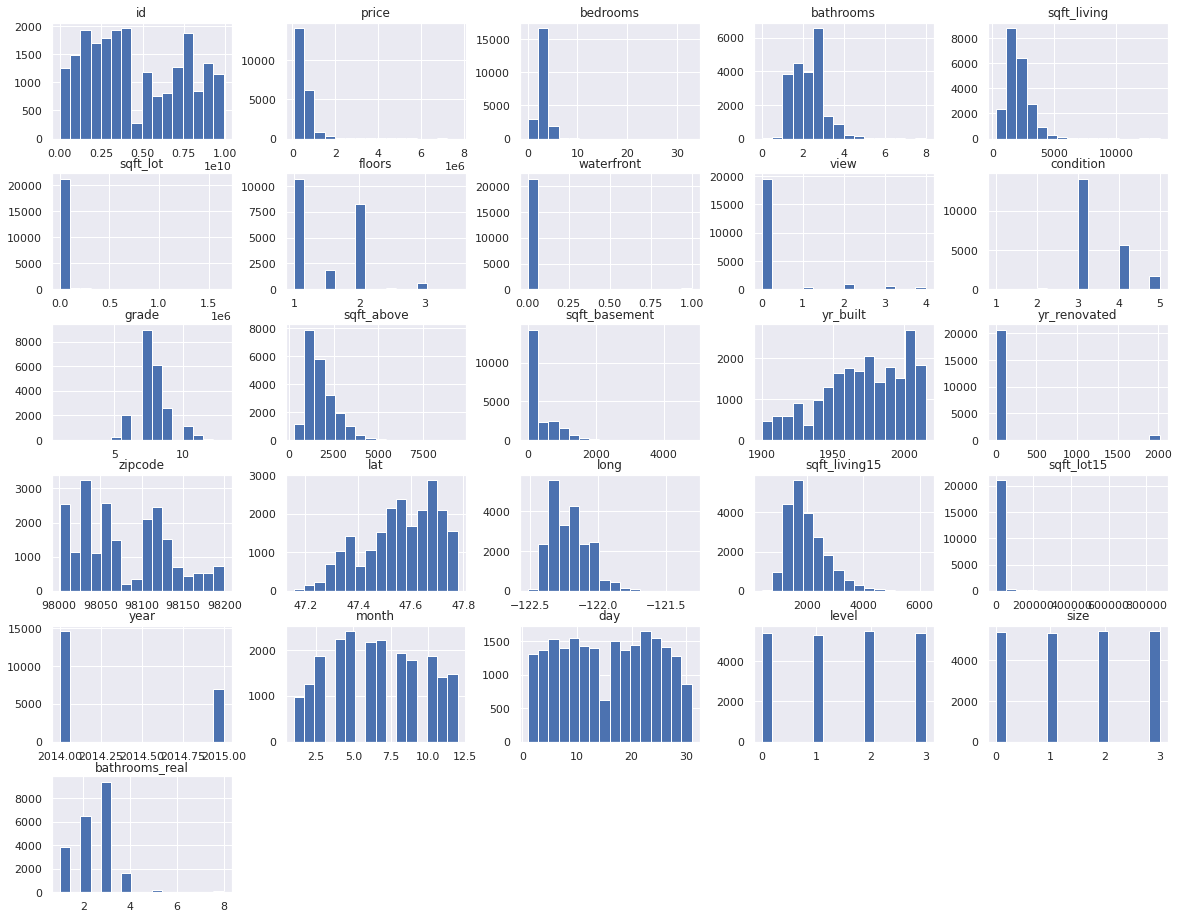

In [50]:
num_attributes.hist(bins=16);

### 3.1.2 Variável Categórica

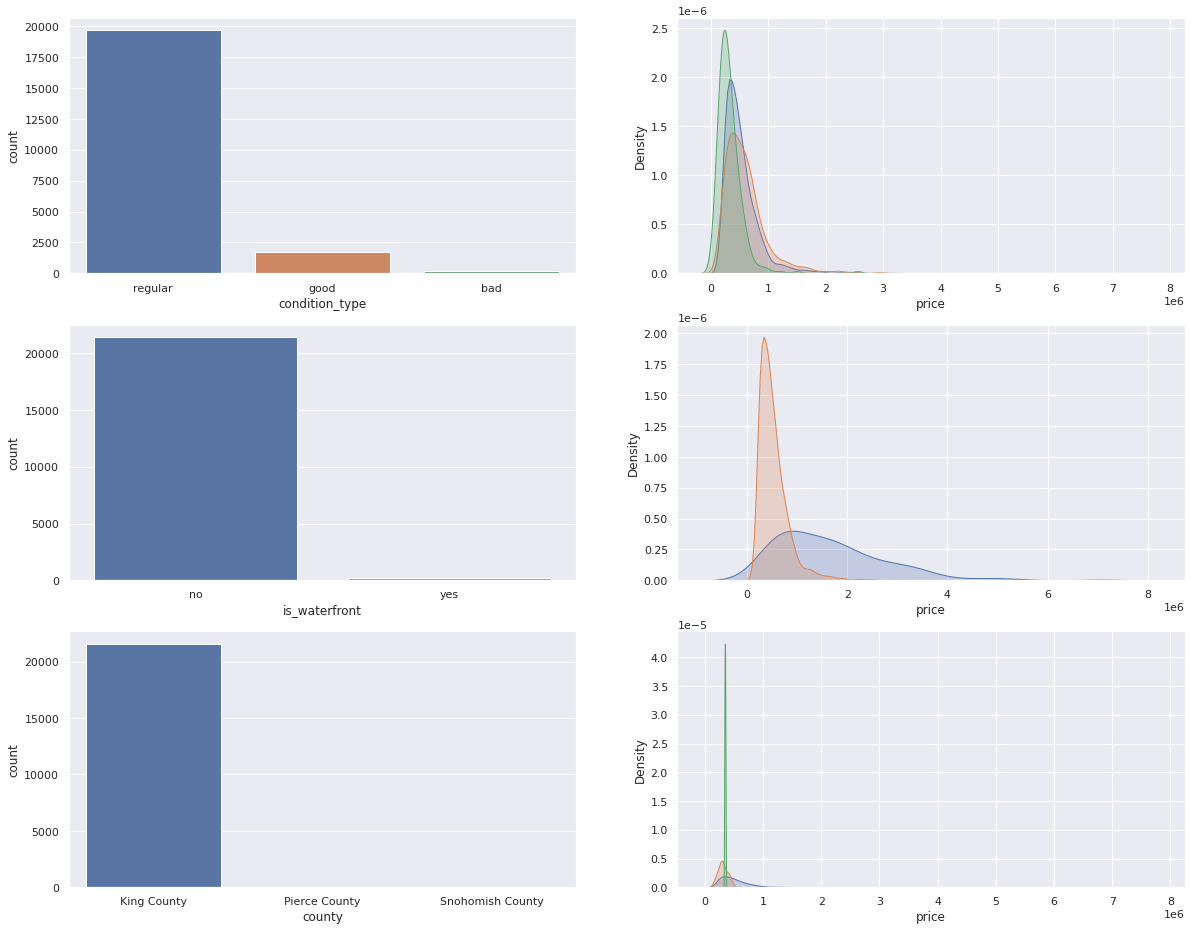

In [51]:
plt.subplot(3,2,1)
sns.countplot(df3['condition_type']);

plt.subplot(3,2,2)
sns.kdeplot(df3[df3['condition_type'] == 'regular']['price'],label = 'regular',shade = True);
sns.kdeplot(df3[df3['condition_type'] == 'good']['price'],label = 'good',shade = True);
sns.kdeplot(df3[df3['condition_type'] == 'bad']['price'],label = 'bad',shade = True);

plt.subplot(3,2,3)
sns.countplot(df3['is_waterfront']);

plt.subplot(3,2,4)
sns.kdeplot(df3[df3['is_waterfront'] == 'yes']['price'],label = 'yes',shade = True);
sns.kdeplot(df3[df3['is_waterfront'] == 'no']['price'],label = 'no',shade = True);

plt.subplot(3,2,5)
sns.countplot(df3['county']);

plt.subplot(3,2,6)
sns.kdeplot(df3[df3['county'] == 'King County']['price'],label = 'King County',shade = True);
sns.kdeplot(df3[df3['county'] == 'Pierce County']['price'],label = 'Pierce County',shade = True);
sns.kdeplot(df3[df3['county'] == 'Snohomish County']['price'],label = 'Snohomish County',shade = True);







## 3.2 Análise Bivariada

### H1 -  Imóveis com mais de 3 quartos vendem mais do  que imóveis com 2 quartos ou menos.

**Verdadeira** Temos mais imóveis vendidos com 3 quartos ou mais do que imóveis com 2 quartos ou menos.

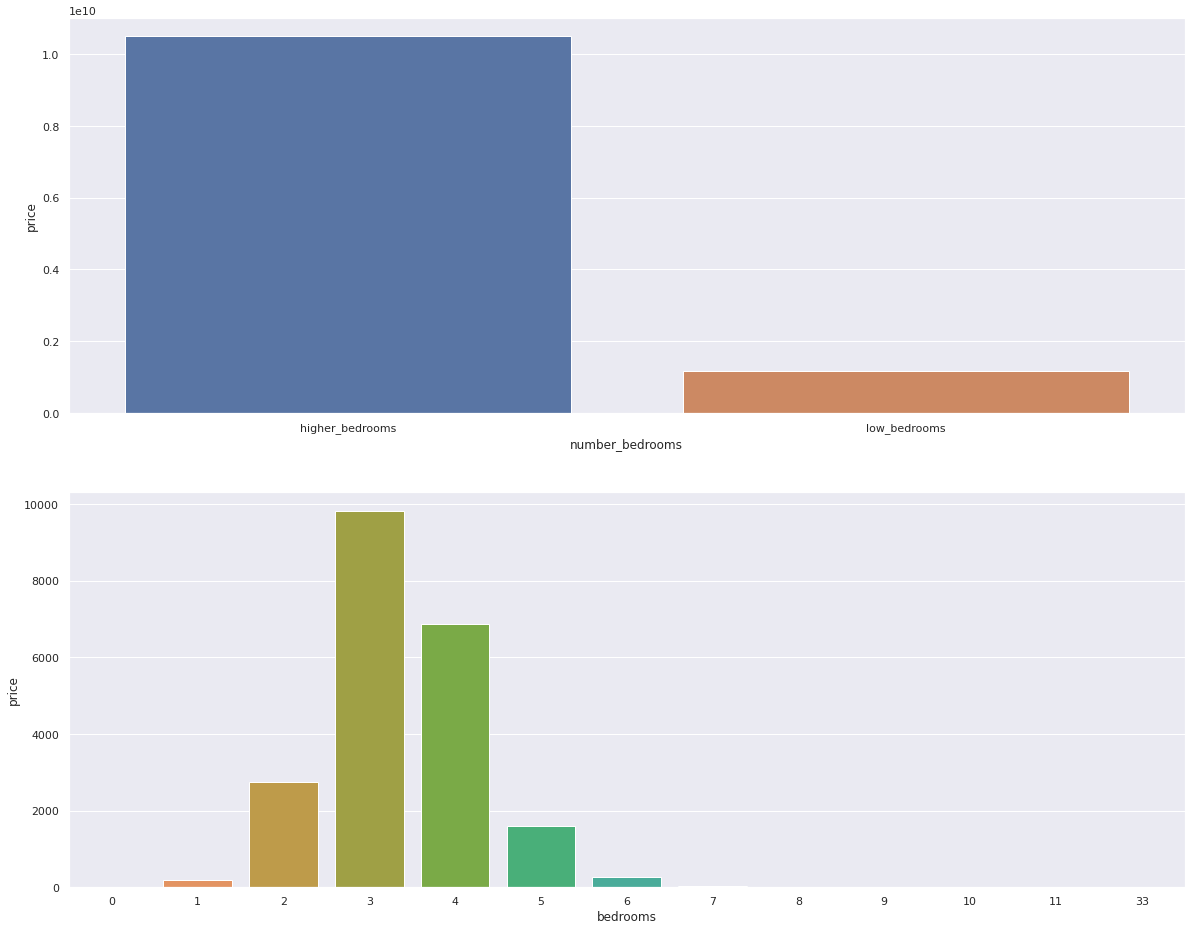

In [52]:
#Verificar se no dataset como está em questão dos quartos
aux = df3[['bedrooms','price']]
aux['number_bedrooms'] = aux['bedrooms'].apply(lambda x: 'low_bedrooms' if x < 3 else 'higher_bedrooms')
aux1 = aux[['number_bedrooms', 'price']].groupby('number_bedrooms').sum().reset_index()

plt.subplot(2,1,1)
sns.barplot(x='number_bedrooms', y='price', data= aux1);

plt.subplot(2,1,2)
aux2 = aux[['bedrooms','price']].groupby('bedrooms').count().reset_index()
sns.barplot(x='bedrooms', y='price', data= aux2);



### H2 -  Imóveis com pelo menos 4 banheiros vendem mais do que imóveis com menos de 4 banheiro.

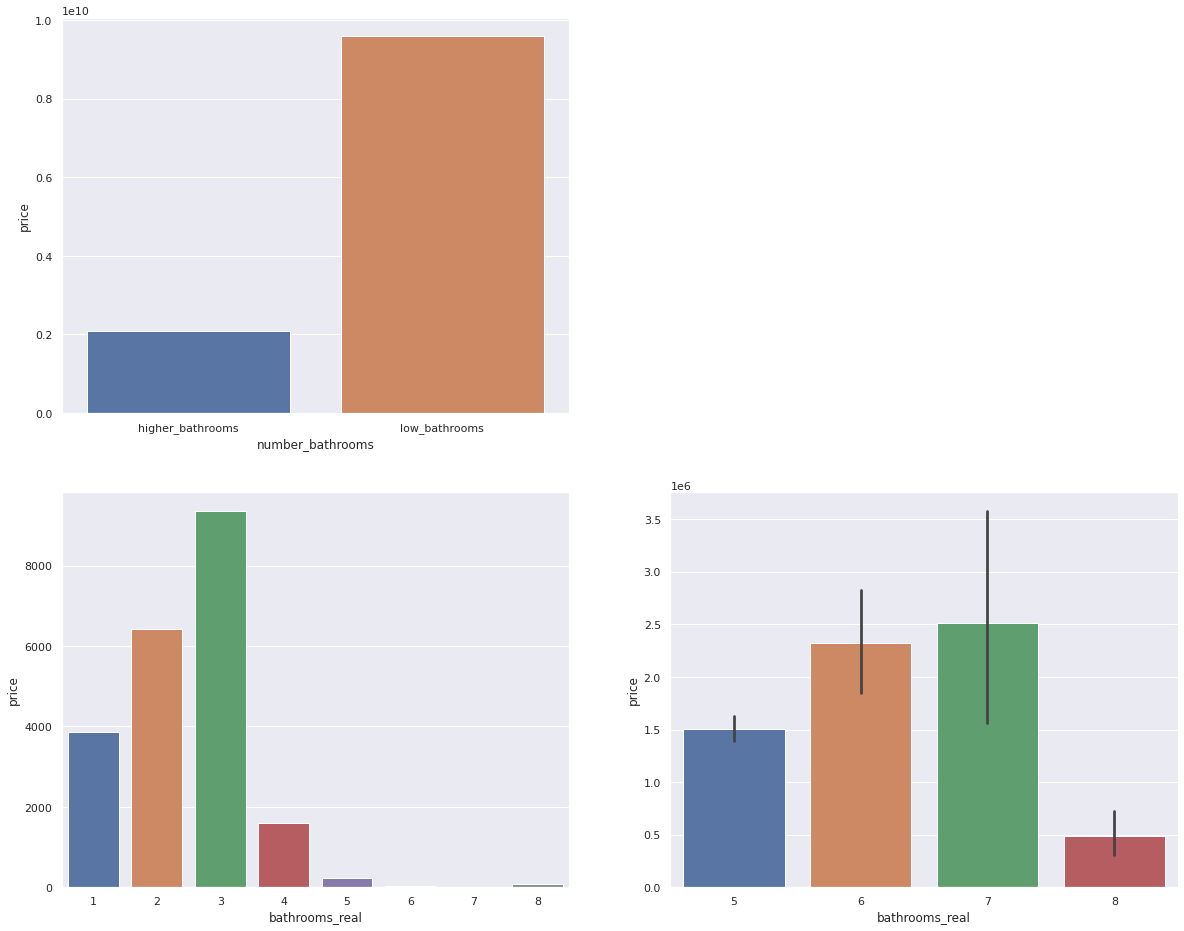

In [53]:
aux = df3[['bathrooms_real','price']]
aux['number_bathrooms'] = aux['bathrooms_real'].apply(lambda x: 'low_bathrooms' if x < 4 else 'higher_bathrooms')
aux1 = aux[['number_bathrooms', 'price']].groupby('number_bathrooms').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x='number_bathrooms', y='price', data= aux1);

plt.subplot(2,2,3)
aux2 = aux[['bathrooms_real','price']].groupby('bathrooms_real').count().reset_index()
sns.barplot(x='bathrooms_real', y='price', data= aux2);

plt.subplot(2,2,4)
aux3 = aux[aux['bathrooms_real'] > 4]
aux4 = aux3[['bathrooms_real','price']].groupby('bathrooms_real').count().reset_index()
sns.barplot(x='bathrooms_real', y='price', data= aux3);


### H3 -  Imóveis com maior metragem maiores que 70 m2 vendem menos do que imóveis com metragem menores.

Falsa 

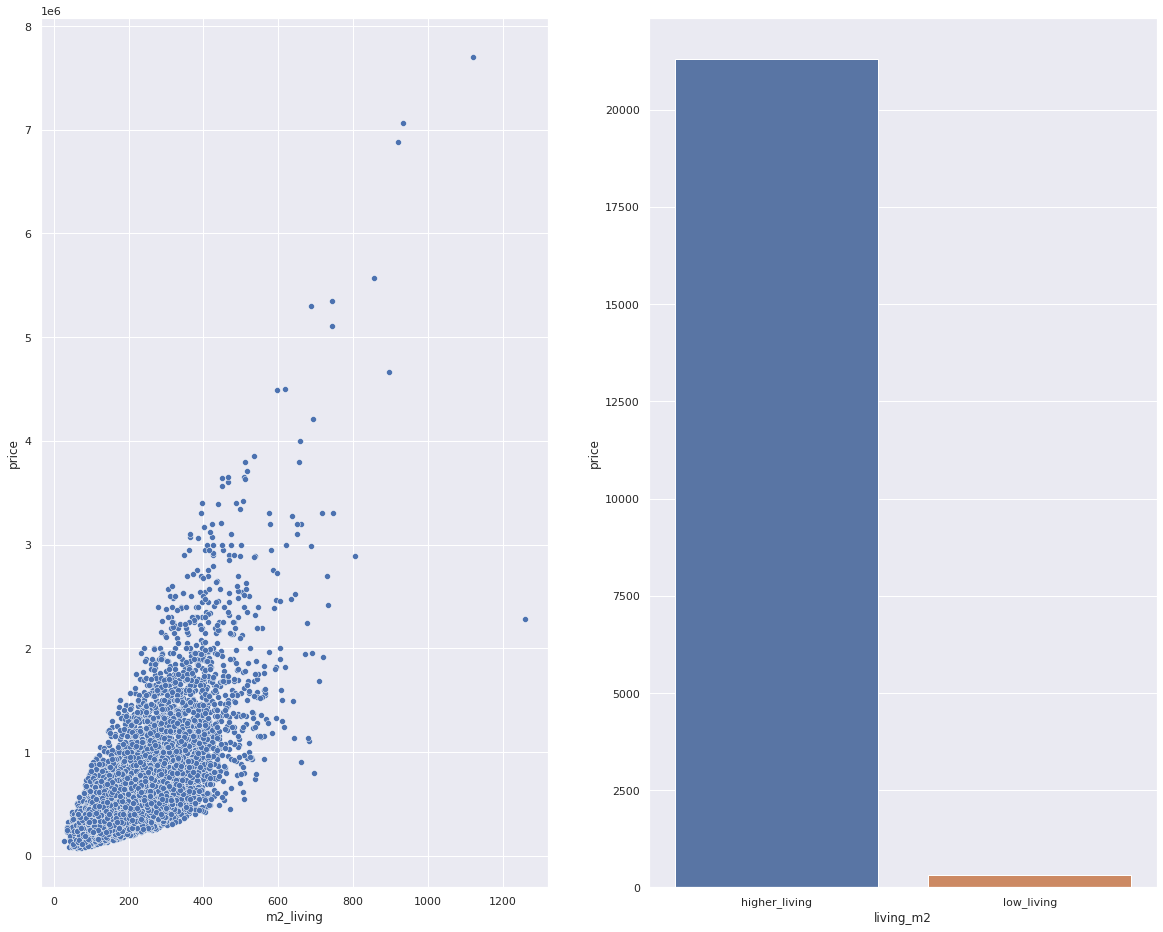

In [54]:
aux = df3[['sqft_living','price']]
aux['m2_living'] = np.round(aux['sqft_living']*0.093,1)

plt.subplot(1,2,1)
sns.scatterplot(x='m2_living', y='price', data= aux);


plt.subplot(1,2,2)
aux['living_m2'] = aux['m2_living'].apply(lambda x: 'low_living' if x < 70 else 'higher_living')
aux1 = aux[['living_m2','price']].groupby('living_m2').count().reset_index()

sns.barplot(x='living_m2', y='price', data= aux1);



### H4 - Imóveis com condições boas vendem mais do que imóveis com condições ruins.

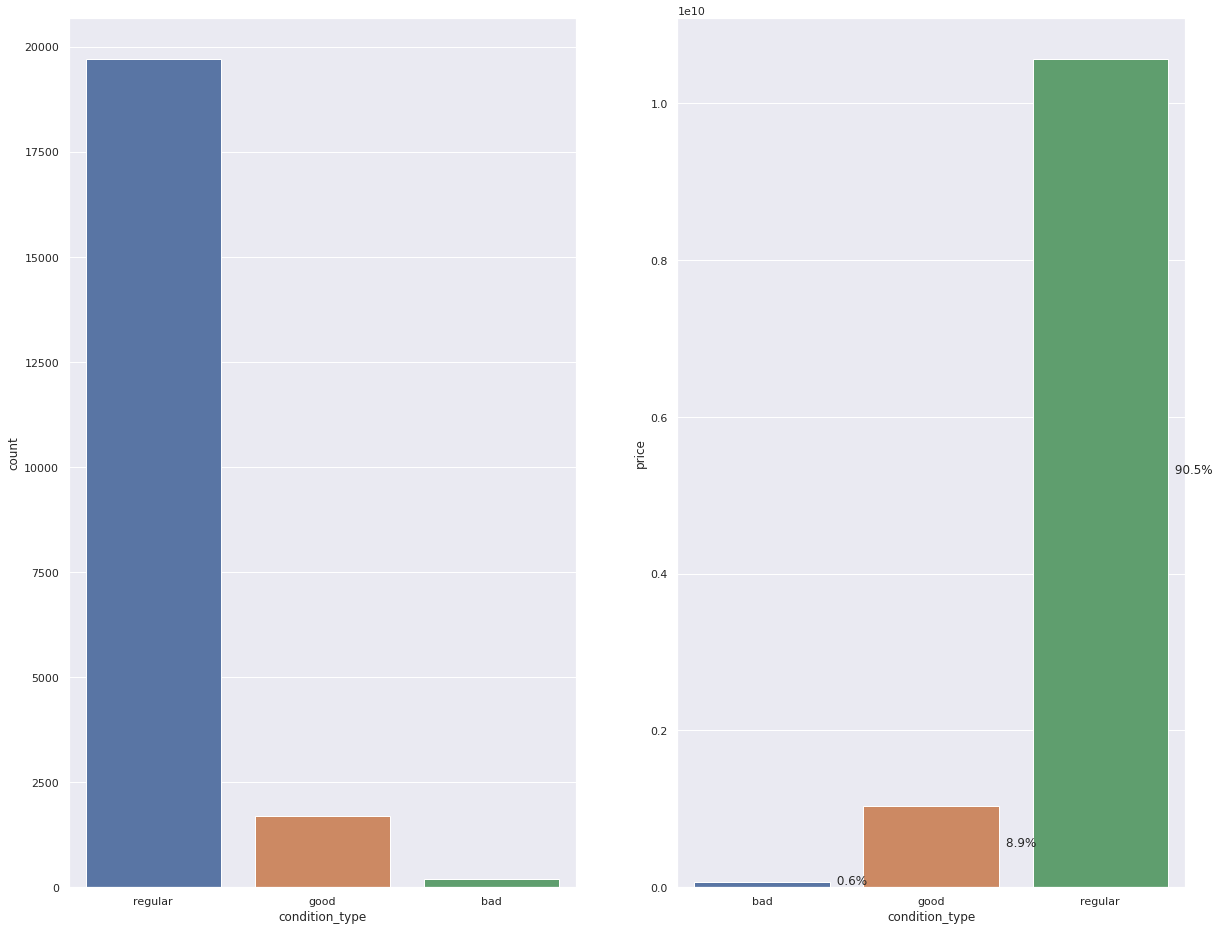

In [55]:
aux = df3[['condition_type','price']]
aux1 = aux[['condition_type','price']].groupby('condition_type').sum().reset_index()

plt.subplot(1,2,1)
sns.countplot(x='condition_type', data= aux);

plt.subplot(1,2,2)
ax = sns.barplot(x='condition_type', y='price', data= aux1);

total = aux1['price'].sum()
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

### H5 - São vendidos mais imóveis no 1º semestre do que no 2º semestre do ano

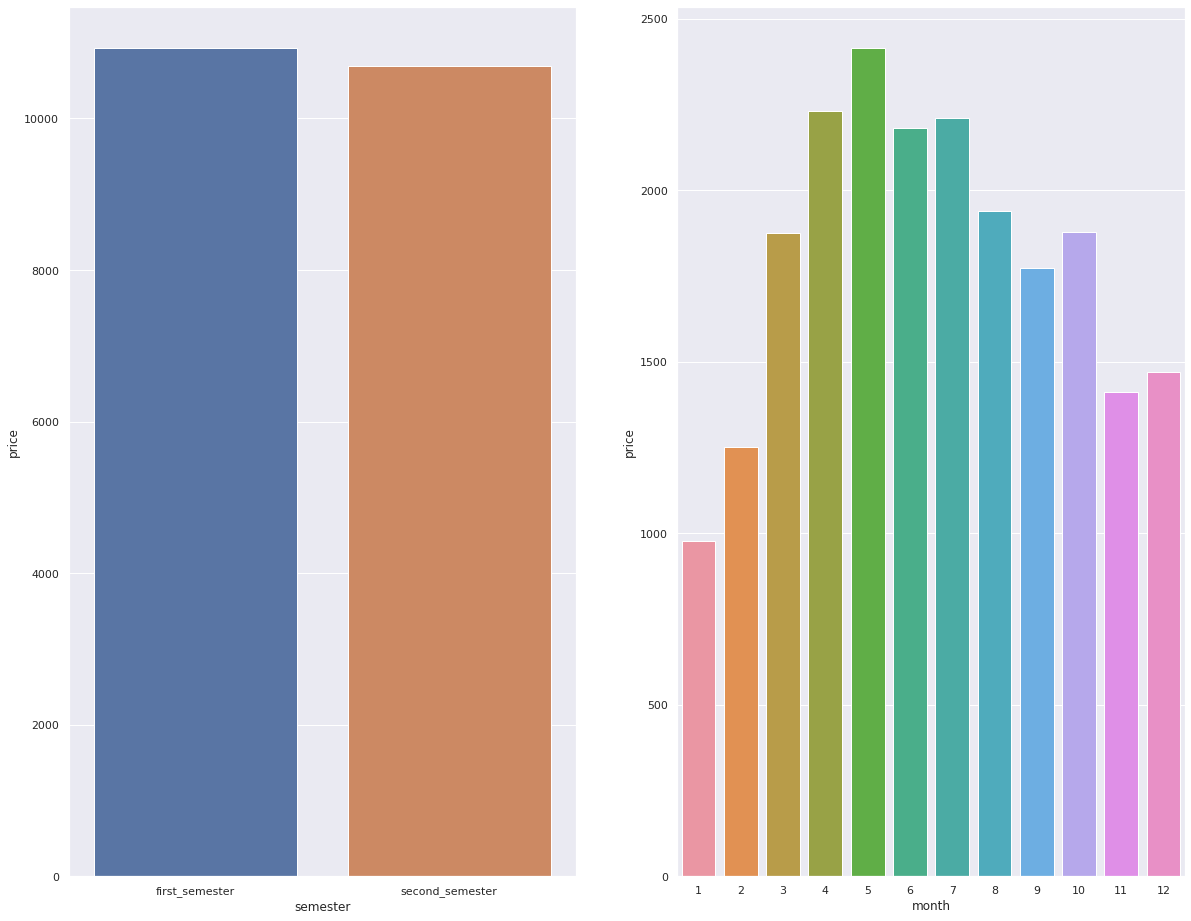

In [56]:
aux = df3[['month','price']]
aux['semester'] = aux['month'].apply(lambda x: 'first_semester' if x <= 6 else 'second_semester')

plt.subplot(1,2,1)
aux1 = aux[['semester','price']].groupby('semester').count().reset_index()
sns.barplot(x='semester', y='price', data= aux1);

plt.subplot(1,2,2)
aux2 = aux[['month','price']].groupby('month').count().reset_index()
sns.barplot(x='month', y='price', data= aux2);

### H6 - As vendas de imóveis nas estações outono e inverno é menor do que nas estações primavera e verão.

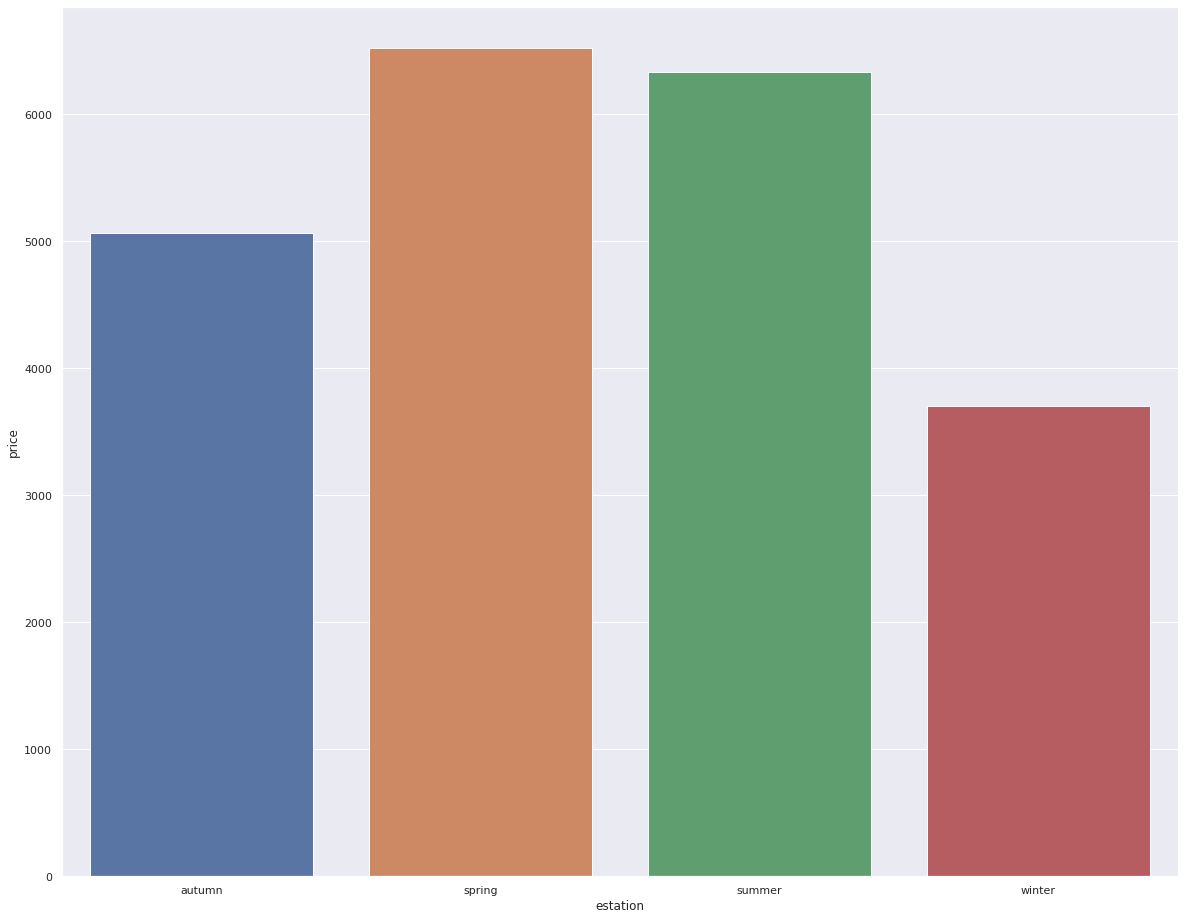

In [57]:
aux = df3[['id','month','price']]
aux['estation'] = aux['month'].apply(lambda x: 'spring' if (x >= 3) & (x <= 5) else 
                                               'summer' if (x >= 6) & (x <=8)  else 
                                               'autumn' if (x >= 9) & (x <=11) else 'winter')
aux1 = aux[['estation','price']].groupby('estation').count().reset_index()
sns.barplot(x='estation', y='price', data= aux1);

### H7 - As vendas de imóveis até o dia 10 de todos os meses é maior que depois do que do resto do mês.

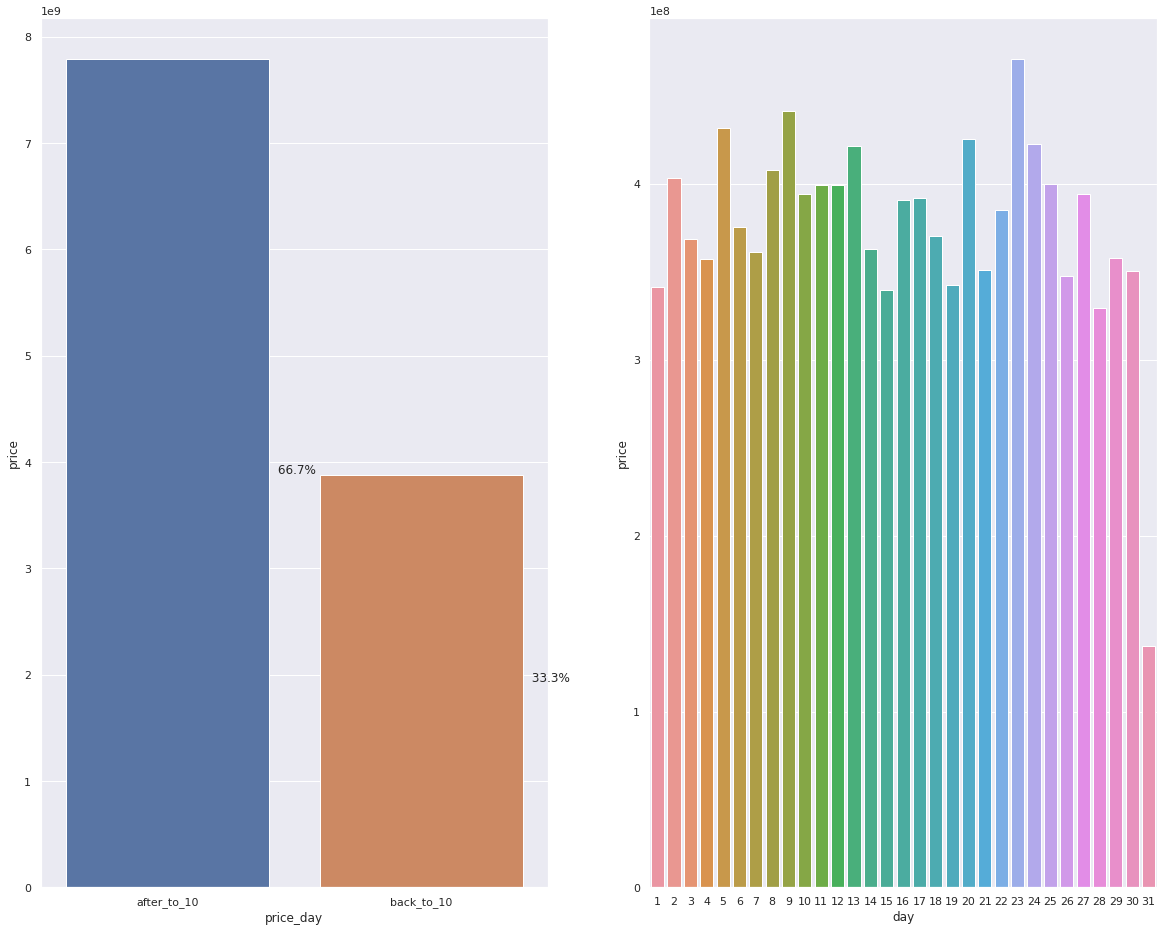

In [58]:
aux = df3[['day','price']]
aux['price_day'] = df3['day'].apply(lambda x: 'back_to_10' if x <= 10 else 'after_to_10')

aux1 = aux[['price_day','price']].groupby('price_day').sum().reset_index()

plt.subplot(1,2,1)
ax = sns.barplot(x='price_day', y='price', data= aux1);

total = aux1['price'].sum()
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

plt.subplot(1,2,2)
aux2 = aux[['day','price']].groupby('day').sum().reset_index()
sns.barplot(x='day', y='price', data= aux2);

### H8 -  Imóveis com localização na praia são mais caros do que imóveis com localização no centro.

Não é interessante analisar esse ponto neste dataset por que a empresa vendeu muito mais imóvel com a localização na praia

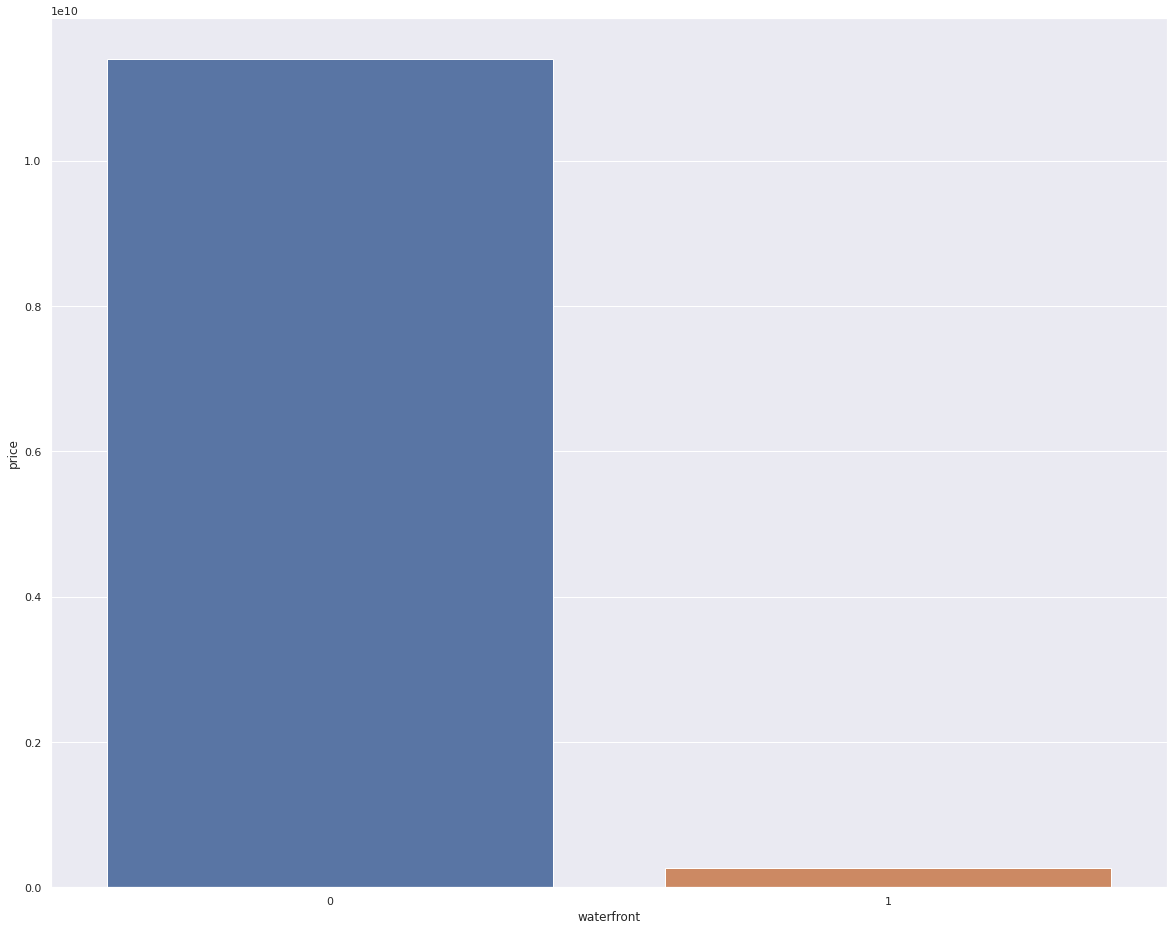

In [59]:
aux = df3[['waterfront','price']]
aux

aux1 = aux[['waterfront','price']].groupby('waterfront').sum().reset_index()
sns.barplot(x='waterfront', y='price', data= aux1);

## 3.3 Análise Multivariada

In [60]:
num_attributes = num_attributes.drop(['id','year','month','day'],axis=1)

### 3.3.1 Atributos Numéricos

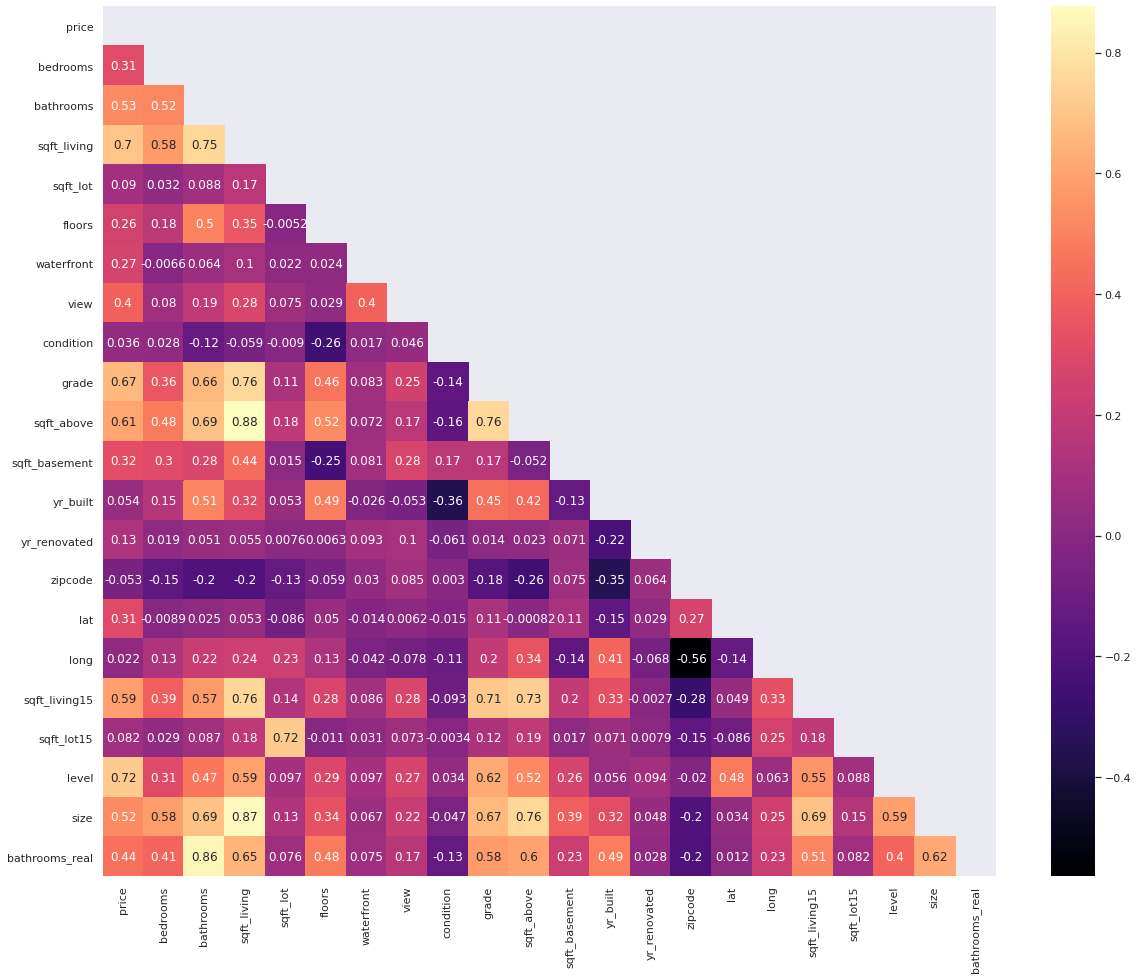

In [61]:
calculate_correlation(num_attributes);

### 3.3.2 Atributos Categóricos

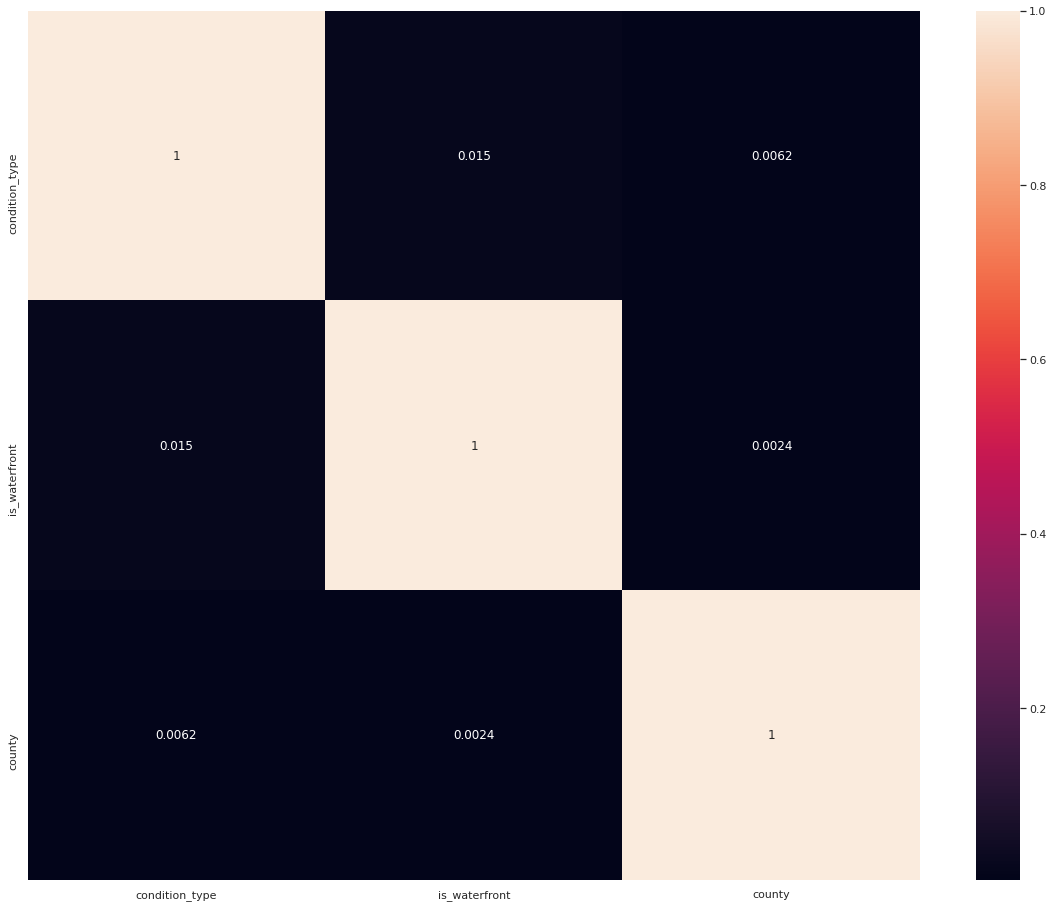

In [62]:
lista_x = ['condition_type', 'is_waterfront','county']
aux = df3[['condition_type', 'is_waterfront','county']]

calculate_cramer(lista_x,aux)

# 4.0 Questões de Negócios



## 4.1 Quais são os imóveis que a House Rocket deveriam comprar e por qual preço?


In [45]:
# Separei as colunas que serão necessárias para a questão
data = df3[['zipcode','county','town','price','condition_type']]

# Agrupar e calcular a mediana por zipcode
df4 = df3[['price','zipcode']].groupby('zipcode').median().reset_index()

# Renomear a coluna de price para price_median
df4 = df4.rename(columns={'price': 'price_median'})

# Realizei um merge dos conjunto de dados
aux01 = pd.merge(data,df4,on='zipcode',how='inner')
aux01['status'] = 'NA'

# Criar a coluna de status para verificar se seria interessante comprar ou não o imóvel
for i in range(len(aux01)):
    if (aux01['price'].loc[i] < aux01['price_median'].loc[i]) & (aux01['condition_type'].loc[i] != 'bad'):
        
        aux01['status'].loc[i] = 'Yes'

    else:
        aux01['status'].loc[i] = 'No'

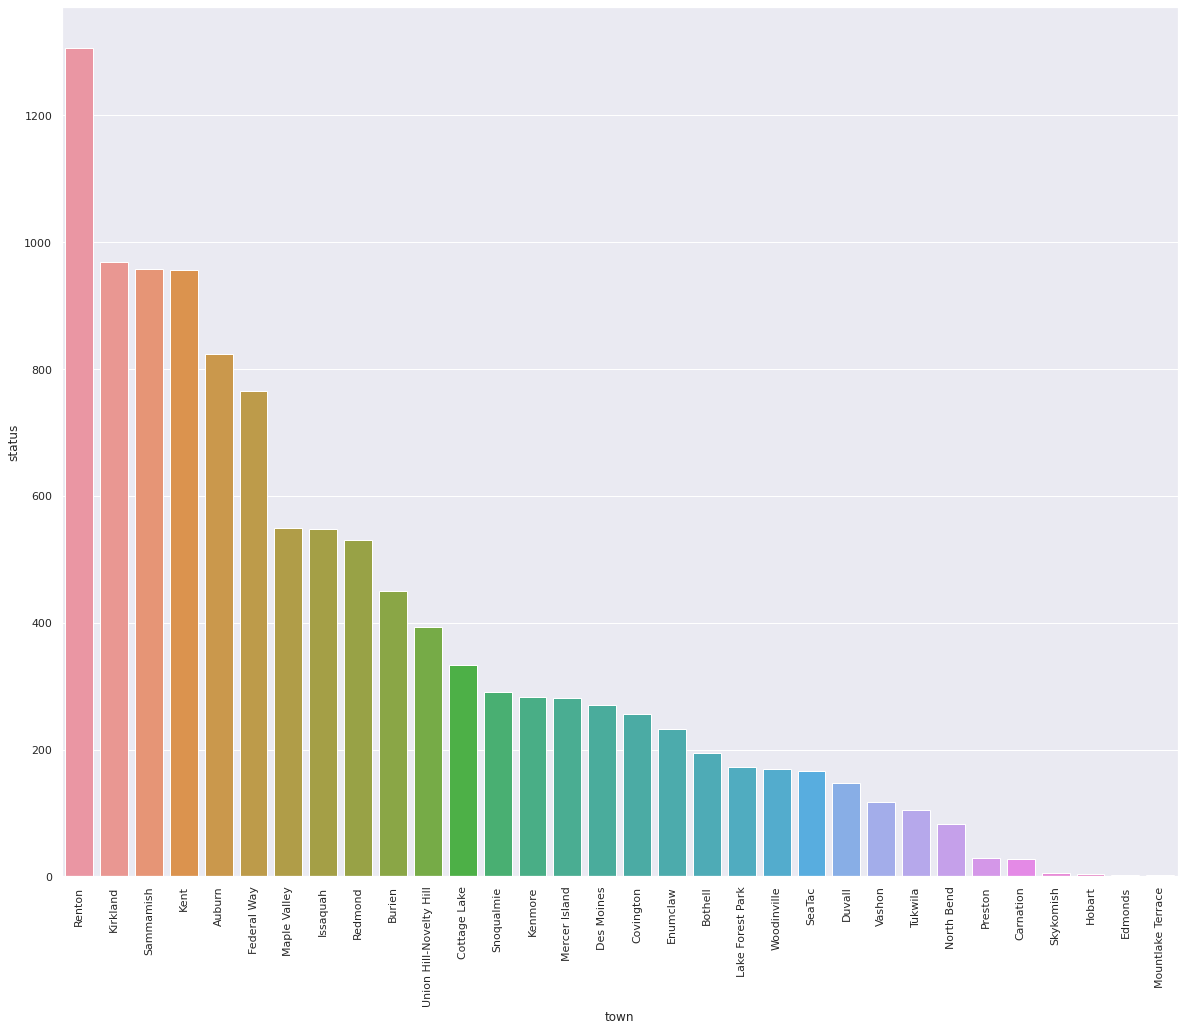

In [47]:
aux03 = aux01[['town','status']].groupby('town').count().reset_index()
aux03 = aux03[['town','status']].sort_values('status',ascending=False).reset_index(drop= True)
plt.tittle =(' Graph Status Yes')
sns.barplot(x='town', y='status', data= aux03);
plt.xticks(rotation=90);



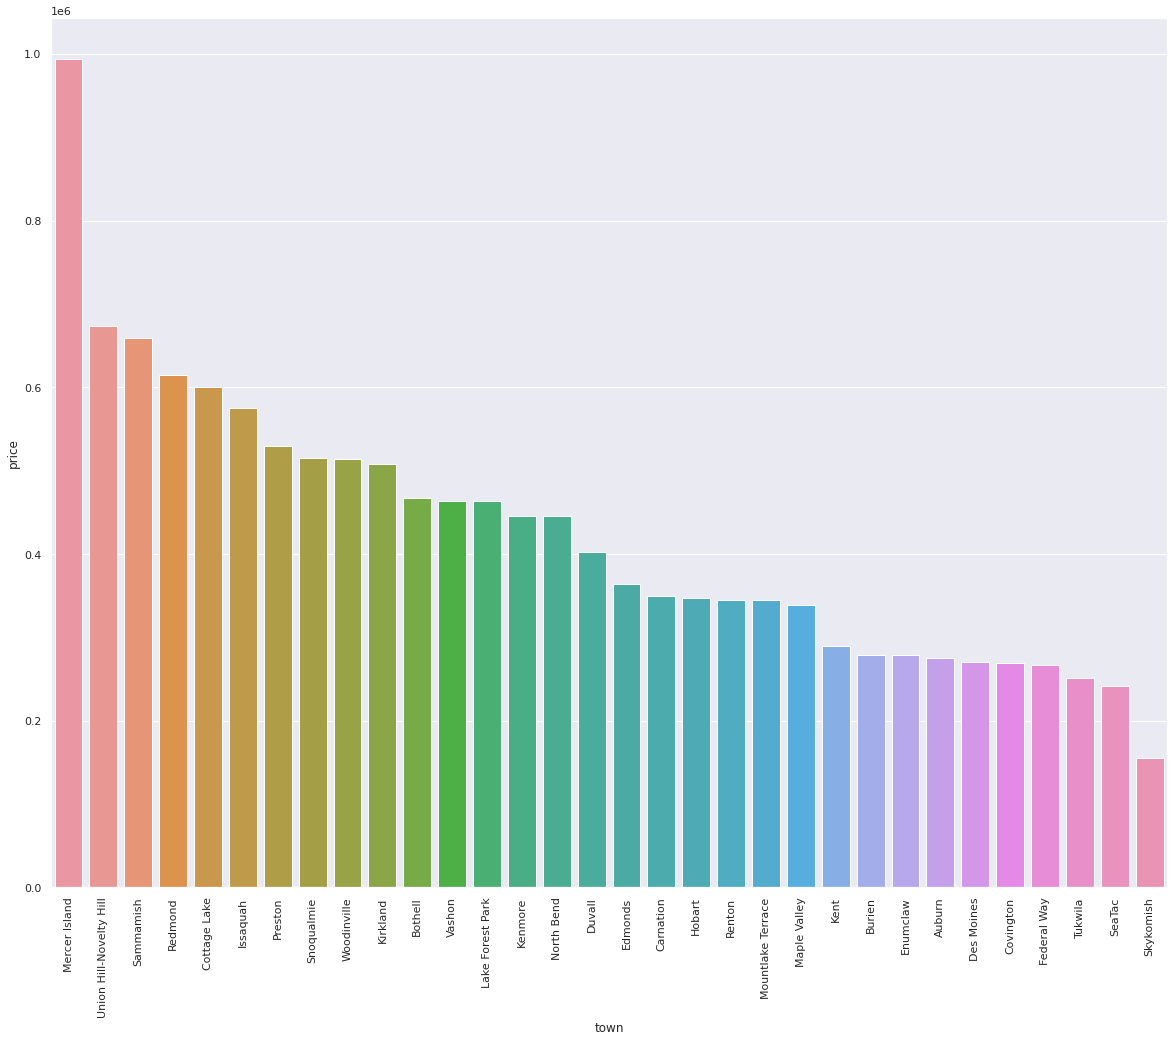

In [48]:
aux03 = aux01[['town','price']].groupby('town').median().reset_index()

aux03 = aux03[['town','price']].sort_values('price',ascending=False).reset_index(drop= True)
sns.barplot(x='town', y='price', data= aux03);
plt.xticks(rotation=90);


## 4.2 Uma vez o imóvel comprado, qual o melhor momento para vendê-lo e por qual preço?

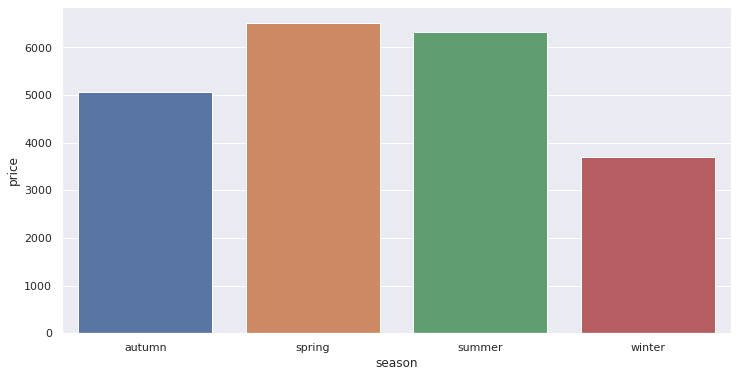

In [40]:
plt.figure(figsize=(12,6))
data = df3[['id','zipcode','month','price','season']]
aux = data[['season','price']].groupby('season').count().reset_index()
sns.barplot(x='season', y='price', data= aux);

In [43]:
f_zipcode = 98003
f_price = 500000
f_season = 'autumn'


# Calculate median of price per region
df = data[['id','zipcode','month','price','season']]

for i in range(len(df)):  
    price_median = df.loc[df['zipcode'] == f_zipcode, 'price'].median() 


    if (f_price <= price_median) & (f_season == 'winter') or (f_season == 'autumn'):
        status = 'Yes'
        worst_scene = f_price + (f_price * 0.10)
        best_scene = f_price + (f_price * 0.15)

    elif (f_price <= price_median) & (f_season == 'summer') or (f_season == 'spring'): 
        status = 'Yes' 
        worst_scene = f_price +(f_price * 0.20)
        best_scene = f_price + (f_price * 0.30)

    else:
        status = 'No' 
        best_scene = 0.0
        worst_scene = 0.0


results = pd.DataFrame({'Zipcode': [f_zipcode],'Price': [f_price],'Season': [f_season],'Price Median': [price_median],'Best Scene': [best_scene],'Worst Scene': [worst_scene],'Purchase Status':[status],})

In [44]:
results

,Zipcode,Price,Season,Price Median,Best Scene,Worst Scene,Purchase Status
0,98003,500000,autumn,267475.00,575000.00,550000.00,Yes
